In [447]:
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as mpimg

# Préparation des données
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Modèles
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Option d'affchage
pd.set_option('display.max_columns', None)

In [448]:
df = pd.read_csv('/Users/lilian/Desktop/hackathon2021/data/train.csv')

/Users/lilian/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (13,32) have mixed types.Specify dtype option on import or set low_memory=False.



In [449]:
#mise au bon format des dates
col_date = ['date', 'items_first_enabled_date', 'store_last_saving_date', 'store_first_saving_date',\
            'pickup_start', 'pickup_end']
for col in col_date :
    df[col]= pd.to_datetime(df[col])
df.drop(columns=['store_country', 'country_iso_code', 'region_id', 'currency_code'], inplace = True)
#redondant ou la même valeur pour tout le dataframe
df.drop(columns=['item_id', 'manual_added_supply','manual_removed_supply','meals_saved', \
 'no_unique_consumers', 'sum_rating_overall', 'rating_count'], inplace= True)
# corrélé à au dessus de 0.75
df.drop(columns=['item_name'], inplace = True) # plus de 84% de valeurs manquantes

In [450]:
df_store = df.drop_duplicates(subset='store_id', keep="first")
df_store.reset_index(inplace= True, drop = True)
df_store = df_store[['store_id', 'parent_chain_id', 'store_region', 'store_segment', 'store_activity_name', \
                    'store_first_saving_date', 'store_last_saving_date']]
# create lifetime column
df_store['lifetime'] = df_store['store_last_saving_date'] - df_store['store_first_saving_date']
no_target_hit = list(df.groupby(by=['store_id']).sum()['target'])
df_store['no_target_hit'] = no_target_hit
df_store['proportion_of_target_hit'] = \
list(df_store['no_target_hit']/pd.to_timedelta(df_store.lifetime, errors='coerce').dt.days)
df_store['no_meals_refunded'] = list(df.groupby(by=['store_id']).sum()['meals_refunded'])
df_store['no_store_cancellation'] = list(df.groupby(by=['store_id']).sum()['store_cancellation'])
df_store['no_consumer_cancellation'] = list(df.groupby(by=['store_id']).sum()['consumer_cancellation'])

In [451]:
df_store = df.drop_duplicates(subset='store_id', keep="first")
df_store.reset_index(inplace= True, drop = True)
df_store = df_store[['store_id', 'parent_chain_id', 'store_region', 'store_segment', 'store_activity_name', \
                    'store_first_saving_date', 'store_last_saving_date']]
presence = df['store_id'].value_counts()
occurence = presence.to_frame(name = 'occurence')
occurence['store_id'] = occurence.index

 

df_store = df_store.merge(occurence, how='inner', on='store_id')

 

# create lifetime column
df_store['lifetime'] = df_store['store_last_saving_date'] - df_store['store_first_saving_date']
df_store['lifetime'] = df_store['lifetime'].dt.days

 

no_target_hit = list(df.groupby(by=['store_id']).sum()['target'])
df_store['no_target_hit'] = no_target_hit

 

df_store['no_meals_refunded'] = list(df.groupby(by=['store_id']).sum()['meals_refunded'])
df_store['no_store_cancellation'] = list(df.groupby(by=['store_id']).sum()['store_cancellation'])
df_store['no_consumer_cancellation'] = list(df.groupby(by=['store_id']).sum()['consumer_cancellation'])

 

df_store['proportion_of_target_hit'] = df_store['no_target_hit']/ df_store['occurence']

 

df_worst = df_store[df_store['proportion_of_target_hit'] >= 0.5]
df_store['worst'] = df_store['store_id'].isin(list(df_worst['store_id']))

In [452]:
df_store.sample(10)

,store_id,parent_chain_id,store_region,store_segment,store_activity_name,store_first_saving_date,store_last_saving_date,occurence,lifetime,no_target_hit,no_meals_refunded,no_store_cancellation,no_consumer_cancellation,proportion_of_target_hit,worst
7014,32348,1203.0,Pays De La Loire,Bakery,Commercial,2018-10-15,2020-03-16,486,518.0,14.0,6,0,24,0.028807,False
15580,55068,3267.0,Lorraine,Buffet,Commercial,2019-12-16,2020-10-29,151,318.0,18.0,0,34,19,0.119205,False
882,25732,4600.0,Ile-De-France,Fast Food / Take away restaurant,Commercial,2017-12-02,2021-03-12,486,1196.0,18.0,16,218,66,0.037037,False
5936,31178,NaN,Rhône-Alpes,Bakery,Commercial,2018-07-13,2018-07-21,189,8.0,160.0,0,0,0,0.846561,True
7992,33484,4987.0,Basse-Normandie,Supermarket Small,Commercial,NaT,NaT,170,NaN,141.0,0,0,0,0.829412,True
16455,60366,4987.0,Ile-De-France,Supermarket Small,Commercial,2020-01-24,2021-03-15,100,416.0,4.0,3,21,17,0.040000,False
16299,59364,4987.0,Pays De La Loire,Supermarket Small,Commercial,2020-01-17,2021-03-15,106,423.0,0.0,1,0,0,0.000000,False
16520,60808,3314.0,Pays De La Loire,Supermarket Big,Commercial,2020-02-03,2021-03-12,111,403.0,11.0,0,3,4,0.099099,False
4179,29318,NaN,Ile-De-France,Fast Food / Take away restaurant,Unknown,2018-03-12,2021-03-10,486,1094.0,63.0,0,57,12,0.129630,False
1535,26627,4582.0,Provence-Alpes-Côte D’Azur,Fast Food / Take away restaurant,Commercial,2017-12-02,2021-03-12,486,1196.0,18.0,14,7,42,0.037037,False


In [453]:
df_store['before_price_mean'] = list(df.groupby(by=['store_id']).mean()['before_price'])



In [454]:
df_store['price_mean'] = list(df.groupby(by=['store_id']).mean()['item_price'])



In [455]:
df_store['reduction'] = 1 - df_store['price_mean'] / df_store['before_price_mean']

In [456]:
df_store.sample(10)

,store_id,parent_chain_id,store_region,store_segment,store_activity_name,store_first_saving_date,store_last_saving_date,occurence,lifetime,no_target_hit,no_meals_refunded,no_store_cancellation,no_consumer_cancellation,proportion_of_target_hit,worst,before_price_mean,price_mean,reduction
2806,27922,4329.0,Alsace,Hotel,Unknown,2017-12-02,2020-03-17,486,836.0,15.0,2,0,29,0.030864,False,NaN,2.00000,NaN
16692,62171,4594.0,Provence-Alpes-Côte D’Azur,Traditional Restaurant,Commercial,2020-02-05,2020-03-13,88,37.0,19.0,1,6,7,0.215909,False,15.000000,4.99000,0.667333
7789,33240,NaN,Pays De La Loire,Bakery,Commercial,2018-11-23,2018-12-01,189,8.0,160.0,0,0,0,0.846561,True,12.000000,3.99000,0.667500
6127,31380,NaN,Alsace,Sushi,Commercial,2018-08-01,2020-12-10,486,862.0,18.0,6,25,16,0.037037,False,15.000000,4.99000,0.667333
7,173,4987.0,Provence-Alpes-Côte D’Azur,Supermarket Small,Commercial,2019-06-25,2020-03-06,311,255.0,72.0,0,0,0,0.231511,False,12.000000,3.99000,0.667500
13723,44101,3650.0,Provence-Alpes-Côte D’Azur,Supermarket Big,Commercial,2019-09-24,2021-03-15,227,538.0,16.0,7,0,10,0.070485,False,12.000000,3.99000,0.667500
16181,58746,4987.0,Poitou-Charentes,Supermarket Small,Commercial,2020-01-14,2021-03-15,108,426.0,0.0,0,5,4,0.000000,False,12.000000,3.99000,0.667500
14332,47181,NaN,Ile-De-France,Fast Food / Take away restaurant,Commercial,2019-10-11,2019-11-01,39,21.0,0.0,1,1,0,0.000000,False,10.512821,3.24641,0.691195
624,25466,NaN,Pays De La Loire,Fast Food / Take away restaurant,Commercial,2017-12-09,2018-08-20,143,254.0,114.0,0,0,0,0.797203,True,8.000000,3.00000,0.625000
8615,34148,3267.0,Languedoc-Roussillon,Fast Food / Take away restaurant,Commercial,2019-03-14,2020-10-29,451,595.0,26.0,1,37,44,0.057650,False,9.000000,3.00000,0.666667


In [457]:
df_store0 = df_store.copy()

In [498]:
df_store = df_store0.copy()

In [499]:
categ_var = ['store_region', 'store_segment']
for var in categ_var:
    df_store = pd.concat([df_store, pd.get_dummies(df_store[var], prefix = var)], axis = 1).drop(columns = [var])

df_store = df_store.drop(columns = ['store_activity_name'])

In [500]:
df_store.sample(10)

,store_id,parent_chain_id,store_first_saving_date,store_last_saving_date,occurence,lifetime,no_target_hit,no_meals_refunded,no_store_cancellation,no_consumer_cancellation,proportion_of_target_hit,worst,before_price_mean,price_mean,reduction,store_region_Alsace,store_region_Aquitaine,store_region_Auvergne,store_region_Basse-Normandie,store_region_Bourgogne,store_region_Bretagne,store_region_Centre - Val De Loire,store_region_Champagne-Ardenne,store_region_Corse,store_region_Franche-Comté,store_region_Haute-Normandie,store_region_Ile-De-France,store_region_Languedoc-Roussillon,store_region_Limousin,store_region_Lorraine,store_region_Midi-Pyrénées,store_region_Nord-Pas De Calais,store_region_Pays De La Loire,store_region_Picardie,store_region_Poitou-Charentes,store_region_Provence-Alpes-Côte D’Azur,store_region_Rhône-Alpes,store_segment_Bakery,store_segment_Beverages,store_segment_Buffet,store_segment_Butcher,store_segment_Cafeteria,store_segment_Canteen,store_segment_Caterer,store_segment_Fast Food / Take away restaurant,store_segment_Fish shop,store_segment_Florist,store_segment_Fruits & vegetables store,store_segment_Gas station,store_segment_Hotel,store_segment_Manufacturer,store_segment_Market stall,store_segment_Other,store_segment_Other Specialists,store_segment_Pastry,store_segment_Supermarket Big,store_segment_Supermarket Medium,store_segment_Supermarket Small,store_segment_Sushi,store_segment_Traditional Restaurant
13554,43886,3650.0,2019-09-21,2021-03-15,227,541.0,15.0,4,3,5,0.066079,False,12.0,3.990000,0.667500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
12267,38150,3534.0,2019-07-16,2021-03-15,354,608.0,0.0,10,9,3,0.000000,False,12.0,10.870056,0.094162,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2268,27378,NaN,2017-12-03,2021-03-15,486,1198.0,0.0,6,20,20,0.000000,False,12.0,4.000000,0.666667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1212,26284,NaN,NaT,NaT,196,NaN,167.0,0,0,0,0.852041,True,8.5,3.500000,0.588235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
13337,43571,4987.0,2019-11-25,2021-03-15,228,476.0,57.0,7,10,19,0.250000,False,12.0,3.990000,0.667500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9336,34930,3671.0,2019-03-12,2021-01-30,428,690.0,18.0,0,100,46,0.042056,False,12.0,3.990000,0.667500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2126,27227,NaN,NaT,NaT,147,NaN,118.0,0,0,0,0.802721,True,12.0,4.000000,0.666667,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8901,34477,3912.0,2019-02-13,2019-06-04,154,111.0,0.0,0,0,1,0.000000,False,NaN,7.000000,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
16297,59359,NaN,2020-01-21,2021-03-15,102,419.0,19.0,5,1,11,0.186275,False,12.0,3.990000,0.667500,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2398,27508,NaN,NaT,NaT,147,NaN,118.0,0,0,0,0.802721,True,NaN,0.000000,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [501]:
#df_store['lifetime'] = df_store['lifetime'].dt.days

In [502]:
df_store['store_first_saving_date'] = df_store.apply(lambda row: row.store_first_saving_date.value, axis = 1)

In [503]:
df_store['store_last_saving_date'] = df_store.apply(lambda row: row.store_last_saving_date.value, axis = 1)

In [504]:
#df_store['saving_date_interval'] = df_store['store_last_saving_date'] - df_store['store_first_saving_date']

In [505]:
df_store = df_store.drop(columns = ['store_last_saving_date', 'store_first_saving_date', 'no_target_hit', 'lifetime', 'worst'])

In [506]:
df1 = df_store.replace(np.nan, 0).dropna().copy()

df1 = df1.replace([np.inf, -np.inf], np.nan).dropna()

In [507]:
x = df1.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df1 = pd.DataFrame(x_scaled, columns = df1.columns)


In [508]:
df1

,store_id,parent_chain_id,occurence,no_meals_refunded,no_store_cancellation,no_consumer_cancellation,proportion_of_target_hit,before_price_mean,price_mean,reduction,store_region_Alsace,store_region_Aquitaine,store_region_Auvergne,store_region_Basse-Normandie,store_region_Bourgogne,store_region_Bretagne,store_region_Centre - Val De Loire,store_region_Champagne-Ardenne,store_region_Corse,store_region_Franche-Comté,store_region_Haute-Normandie,store_region_Ile-De-France,store_region_Languedoc-Roussillon,store_region_Limousin,store_region_Lorraine,store_region_Midi-Pyrénées,store_region_Nord-Pas De Calais,store_region_Pays De La Loire,store_region_Picardie,store_region_Poitou-Charentes,store_region_Provence-Alpes-Côte D’Azur,store_region_Rhône-Alpes,store_segment_Bakery,store_segment_Beverages,store_segment_Buffet,store_segment_Butcher,store_segment_Cafeteria,store_segment_Canteen,store_segment_Caterer,store_segment_Fast Food / Take away restaurant,store_segment_Fish shop,store_segment_Florist,store_segment_Fruits & vegetables store,store_segment_Gas station,store_segment_Hotel,store_segment_Manufacturer,store_segment_Market stall,store_segment_Other,store_segment_Other Specialists,store_segment_Pastry,store_segment_Supermarket Big,store_segment_Supermarket Medium,store_segment_Supermarket Small,store_segment_Sushi,store_segment_Traditional Restaurant
0,0.000000,0.000000,0.188874,0.016216,0.005096,0.031933,0.202259,0.080000,0.058281,0.927914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000238,0.192630,0.224588,0.000000,0.000566,0.001681,0.227055,0.080669,0.059257,0.926953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.000861,0.000000,0.164148,0.005405,0.003964,0.000000,0.000000,0.280166,0.204615,0.927625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.000888,0.000000,0.160714,0.000000,0.002831,0.000000,0.000000,0.280000,0.204494,0.927625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.000901,0.000000,0.160027,0.000000,0.000000,0.000000,0.737299,0.280170,0.204618,0.927625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17895,0.998543,0.000000,0.001374,0.000000,0.000000,0.000000,0.000000,0.080000,0.058281,0.927914,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17896,0.998675,0.671181,0.004121,0.000000,0.000000,0.000000,0.000000,0.300000,0.218954,0.927702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
17897,0.998794,0.289874,0.000687,0.000000,0.000000,0.000000,0.000000,0.080000,0.058281,0.927914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17898,0.999059,0.272960,0.000687,0.000000,0.000000,0.000000,0.000000,0.080000,0.058281,0.927914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [509]:
y = df1[['proportion_of_target_hit']]
X = df1.drop(columns = ['proportion_of_target_hit'])

# On choisit un échantillon de validation de 20 %

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [510]:
y.sample(10)

,proportion_of_target_hit
8853,0.171375
16988,0.282959
15559,0.103065
11946,0.000000
1217,0.884006
16180,0.180851
14913,0.073303
7063,0.000000
10921,0.462934
12272,0.209835


In [511]:
lin_reg = LinearRegression().fit(X_train, y_train)

# On prédit à partir de l'échantillon de test pour calculer les scores

y_pred = lin_reg.predict(X_test)

In [512]:
px.histogram(pd.DataFrame([
    (X.columns[i], lin_reg.coef_[0][i]) for i in range(53)
                    ]).T.rename(index = {0 : 'variable', 1 : 'coeff'}).T, x = 'variable', y = 'coeff', histfunc = 'sum'
            ).show()

print('MSE :', mean_squared_error(y_test, y_pred))

MSE : 0.055165576642285406


In [513]:
def poly_reg(n):
    """
    Cette fonction effectue une regression polynomiale sur la base d'entrainement et affiche 
    la MSE pour l'echantillon de test
    """
    
    # Agrandissement de la base d'entrainement avec l'ajout des degrés successifs
    poly_X = X_train.copy()
    
    for i in range(2, n+1):
        
        index = [str(j) + '^' + str(i) for j in X.columns[:32]]
        poly_X[[str(j) + '^' + str(i) for j in X.columns[:32]]] = poly_X[[j for j in X.columns[:32]]].pow(i)
    
    poly_reg = LinearRegression().fit(poly_X, y_train)
    
    # Agrandissement de la base d'de test avec l'ajout des degrés successifs
    poly_X_test = X_test.copy()
    
    for i in range(2, n+1):
        
        index = [str(j) + '^' + str(i) for j in X.columns[:32]]
        poly_X_test[[str(j) + '^' + str(i) for j in X.columns[:32]]] = poly_X_test[[j for j in X.columns[:32]]].pow(i)
    
    # Regression
    y_pred = poly_reg.predict(poly_X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Affichage des coefficients pour le degré 2
    fig = px.histogram(pd.DataFrame([
        (poly_X.columns[i], poly_reg.coef_[0][i]) for i in range(28 + 32 * (n - 1))
                            ]).T.rename(
        index = {0 : 'variable', 1 : 'coeff'}
                                        ).T.sort_values(by = 'variable'), x = 'variable', y = 'coeff') 
    
    if n == 2:
        
        fig.show()
        
    else:
        
        print('degré : ', n)

    return MSE

In [514]:
# Regressions jusqu'à l'overfitting (MSE > 0.4 sur l'échantillon test)

i = 2
val = poly_reg(2)
list_mse_degree = [val]


while val < .016:
    i += 1
    val = poly_reg(i)
    list_mse_degree.append(val) 
    
    if i > 25:
        break
    

px.line(x = [i + 2 for i in range(len(list_mse_degree))], y = list_mse_degree).show()

In [515]:
EN_reg = ElasticNet(alpha=.1, copy_X=True, fit_intercept = False, l1_ratio=.0009)

EN_reg.fit(X_train, y_train)

ElasticNet(alpha=0.1, fit_intercept=False, l1_ratio=0.0009)

In [516]:
y_pred = EN_reg.predict(X_test)
print('MSE : ', mean_squared_error(y_test, y_pred))

MSE :  0.09060299710279748


In [517]:
pd.DataFrame([(X.columns[i], EN_reg.coef_[i]) for i in range(53)]).T.rename(index = {0 : 'variable', 1 : 'coeff'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
variable,store_id,parent_chain_id,occurence,no_meals_refunded,no_store_cancellation,no_consumer_cancellation,before_price_mean,price_mean,reduction,store_region_Alsace,store_region_Aquitaine,store_region_Auvergne,store_region_Basse-Normandie,store_region_Bourgogne,store_region_Bretagne,store_region_Centre - Val De Loire,store_region_Champagne-Ardenne,store_region_Corse,store_region_Franche-Comté,store_region_Haute-Normandie,store_region_Ile-De-France,store_region_Languedoc-Roussillon,store_region_Limousin,store_region_Lorraine,store_region_Midi-Pyrénées,store_region_Nord-Pas De Calais,store_region_Pays De La Loire,store_region_Picardie,store_region_Poitou-Charentes,store_region_Provence-Alpes-Côte D’Azur,store_region_Rhône-Alpes,store_segment_Bakery,store_segment_Beverages,store_segment_Buffet,store_segment_Butcher,store_segment_Cafeteria,store_segment_Canteen,store_segment_Caterer,store_segment_Fast Food / Take away restaurant,store_segment_Fish shop,store_segment_Florist,store_segment_Fruits & vegetables store,store_segment_Gas station,store_segment_Hotel,store_segment_Manufacturer,store_segment_Market stall,store_segment_Other,store_segment_Other Specialists,store_segment_Pastry,store_segment_Supermarket Big,store_segment_Supermarket Medium,store_segment_Supermarket Small,store_segment_Sushi
coeff,0.052175,-0.0431516,-0.0712999,-0.0403316,-0.0151103,-0.052499,0.0131546,0.0172452,0.215389,0.0139122,0.0289885,0.000204065,0,0.00127503,0.00885388,-0.00432091,0.00936501,-0.00063129,0.000524187,0.00336163,0.0725212,0.0136582,-0,0.000797458,0.0173097,0.0103152,0.0129414,-0.00291379,0.010046,0.0255361,0.0299968,-0.045892,0.0130359,-0.00285368,0.00204301,0.0210229,0.0137738,0.018529,0.0438601,0.00279876,0.00490691,0.000753974,0,0.0184966,-0.000283771,0.00099108,0.0406355,0.0188737,0.0227994,-0.000646495,-0.00255895,-0.0417999,-0.00300685


lifetime, no_target_hit, reduction, store_region_Aquitaine, store_region_Ile-De-France, store_region_Languedoc-Roussillon, 
store_region_Rhône-Alpes, store_segment_Fast Food / Take away restaurant, store_segment_Supermarket Small

In [518]:
# On définit d'abord une fonction qui donne l'importance des variables vis à vis d'un certain modèle

def feat_importance(model, x_train, y_train, X):
    """
    Renvoie le tableau de l'importance des variables vis à vis du modèle par la méthode des permutations
    """

    result = permutation_importance(
                                    model, 
                                    X, 
                                    y, 
                                    n_repeats = 3,
                                    random_state = 0
                                    )['importances_mean']
    
    importance = pd.DataFrame(result, index = X.columns, columns = ["Importance"])
    
    return importance.sort_values(by = ['Importance'], ascending = False)

In [519]:
# Création des essembles de tests et d'entrainement, on choisit une taile de test de 30% ici

X = df1.drop(['proportion_of_target_hit'], axis = 1)
x = np.array(X)
y = np.array(df1['proportion_of_target_hit'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 41)
# random_state correspond à la graine générant l'échantillon aléatoire

In [520]:
max_depth_ls = [1, 10, 13, 15, 17, 20, 25, 30] # profondeurs maximales des arbres de décision testées
mse_train_max_depth = []
mse_test_max_depth = []

# Pour chaque profondeur max, on regresse avec random forest

for m in max_depth_ls :
    
    print('Profondeur téstée : ', m)
    
    rf = RandomForestRegressor(
                            max_depth = m, 
                            random_state=0,
                            n_estimators = 30) # nombre d'arbres utilisés
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    
    mse_train_max_depth.append(mean_squared_error(y_train, y_pred_train))
    mse_test_max_depth.append(mean_squared_error(y_test, y_pred))

Profondeur téstée :  1
Profondeur téstée :  10
Profondeur téstée :  13
Profondeur téstée :  15
Profondeur téstée :  17
Profondeur téstée :  20
Profondeur téstée :  25
Profondeur téstée :  30


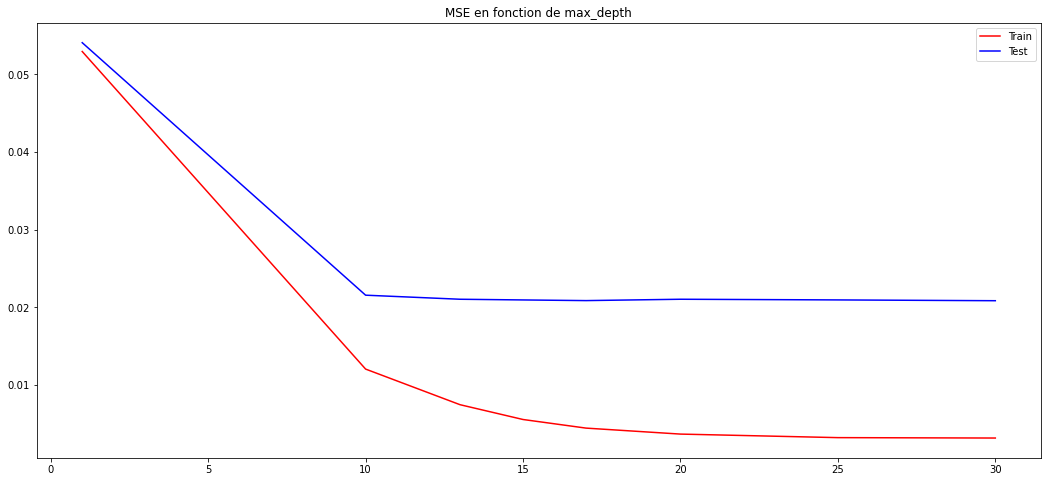

In [521]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(max_depth_ls, mse_train_max_depth, color = 'red', label = 'Train')
plt.plot(max_depth_ls, mse_test_max_depth, color = 'blue', label = 'Test')
plt.title('MSE en fonction de max_depth')
plt.legend()
plt.show()

In [522]:
# On regarde maintenant l'effet du nombre d'arbre sur l'effet de la regression

nb_estimators_ls = [1, 2, 3, 5, 20, 40, 50, 60, 80]
mse_train_nb_estimators = []
mse_test_nb_estimators = []

for m in nb_estimators_ls :
    print("Nombre d'arbres testés : ", m)
    rf = RandomForestRegressor(max_depth = 10, 
                               random_state = 0,
                                n_estimators = m)    
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    
    mse_train_nb_estimators.append(mean_squared_error(y_train, y_pred_train))
    mse_test_nb_estimators.append(mean_squared_error(y_test, y_pred))



Nombre d'arbres testés :  1
Nombre d'arbres testés :  2
Nombre d'arbres testés :  3
Nombre d'arbres testés :  5
Nombre d'arbres testés :  20
Nombre d'arbres testés :  40
Nombre d'arbres testés :  50
Nombre d'arbres testés :  60
Nombre d'arbres testés :  80


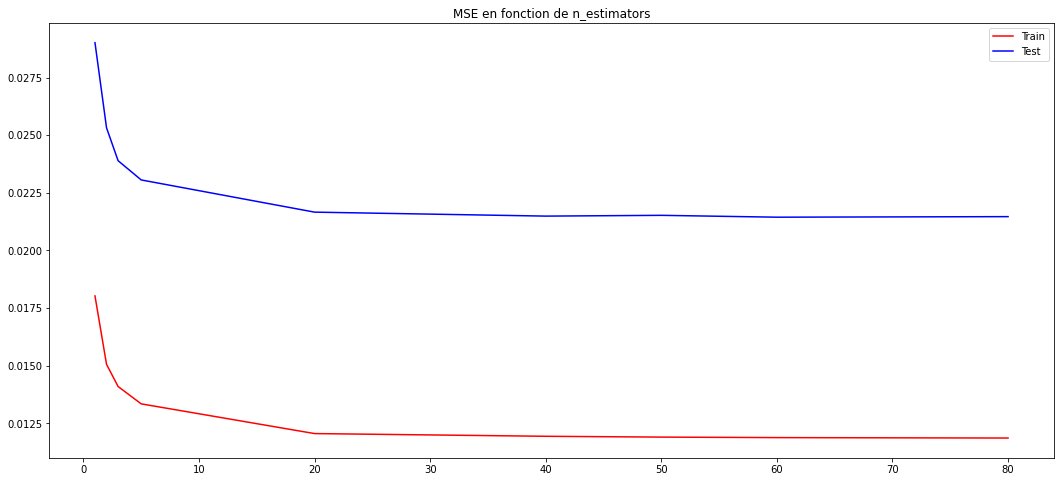

In [523]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(nb_estimators_ls, mse_train_nb_estimators, color = 'red', label = 'Train')
plt.plot(nb_estimators_ls, mse_test_nb_estimators, color = 'blue', label = 'Test')
plt.title('MSE en fonction de n_estimators')
plt.legend()
plt.show()

In [524]:
# On fait varier le nombre minimum d'exemple requis pour créer une feuille/noeud

samples_leaf_ls = [1, 2, 3, 4, 10]
mse_train_samples_leaf = []
mse_test_samples_leaf = []


for m in samples_leaf_ls :
    print('min_samples_leaf testé : ', m)
    rf = RandomForestRegressor( max_depth = 10, 
                                min_samples_leaf = m,
                                n_estimators = 40, 
                                random_state = 0
                              )    
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    
    mse_train_samples_leaf.append(mean_squared_error(y_train, y_pred_train))
    mse_test_samples_leaf.append(mean_squared_error(y_test, y_pred))

min_samples_leaf testé :  1
min_samples_leaf testé :  2
min_samples_leaf testé :  3
min_samples_leaf testé :  4
min_samples_leaf testé :  10


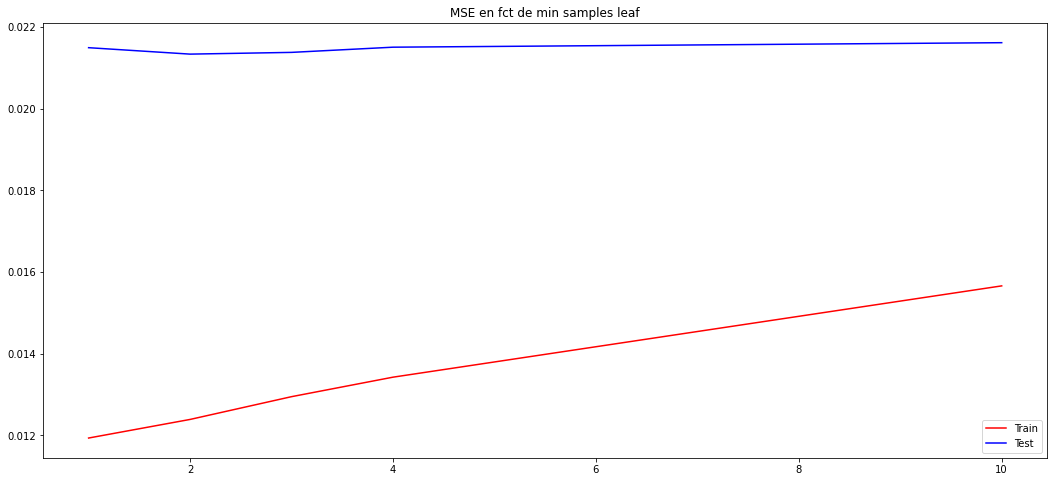

In [525]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(samples_leaf_ls, mse_train_samples_leaf, color='red', label='Train')
plt.plot(samples_leaf_ls, mse_test_samples_leaf, color='blue', label='Test')
plt.title('MSE en fct de min samples leaf')
plt.legend()
plt.show()

In [526]:
max_leaf_ls = [2, 10, 100, 150, 200, 1000, 1500]
mse_train_max_leaf = []
mse_test_max_leaf = []



for m in max_leaf_ls :
    
    print('Nombre de feuilles max testé : ', m)
    rf = RandomForestRegressor(max_depth = 10, 
                               min_samples_leaf = 1, 
                               max_leaf_nodes = m,
                               n_estimators = 40)   
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    mse_train_max_leaf.append(mean_squared_error(y_train, y_pred_train))
    mse_test_max_leaf.append(mean_squared_error(y_test, y_pred))

Nombre de feuilles max testé :  2
Nombre de feuilles max testé :  10
Nombre de feuilles max testé :  100
Nombre de feuilles max testé :  150
Nombre de feuilles max testé :  200
Nombre de feuilles max testé :  1000
Nombre de feuilles max testé :  1500


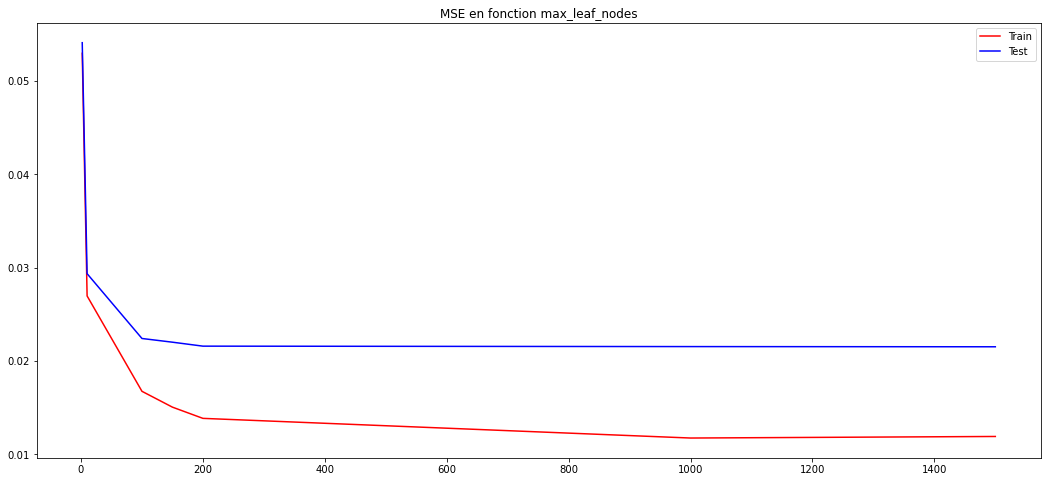

In [527]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(max_leaf_ls, mse_train_max_leaf, color = 'red', label = 'Train')
plt.plot(max_leaf_ls, mse_test_max_leaf, color = 'blue', label = 'Test')
plt.title('MSE en fonction max_leaf_nodes')
plt.legend()
plt.show()

In [528]:
# On a maintenant tous nos paramètres

rf = RandomForestRegressor(
                        max_depth = 15, 
                        min_samples_leaf = 1, 
                        max_leaf_nodes = 1000,
                        n_estimators = 60
                            )    

rf = rf.fit(x_train, y_train)
y_pred_train = rf.predict(x_train)
y_pred = rf.predict(x_test)
oo = np.zeros(y_pred.shape)

print('MSE train : ', mean_squared_error(y_train, y_pred_train))
print('MSE test : ', mean_squared_error(y_test, y_pred))
print('MSE modèle nulle : ', mean_squared_error(y_test, oo))

importance = feat_importance(rf, x_train, y_train, X)

MSE train :  0.0058795885801739564
MSE test :  0.020686904358122146
MSE modèle nulle :  0.1605107010728511


<AxesSubplot:>

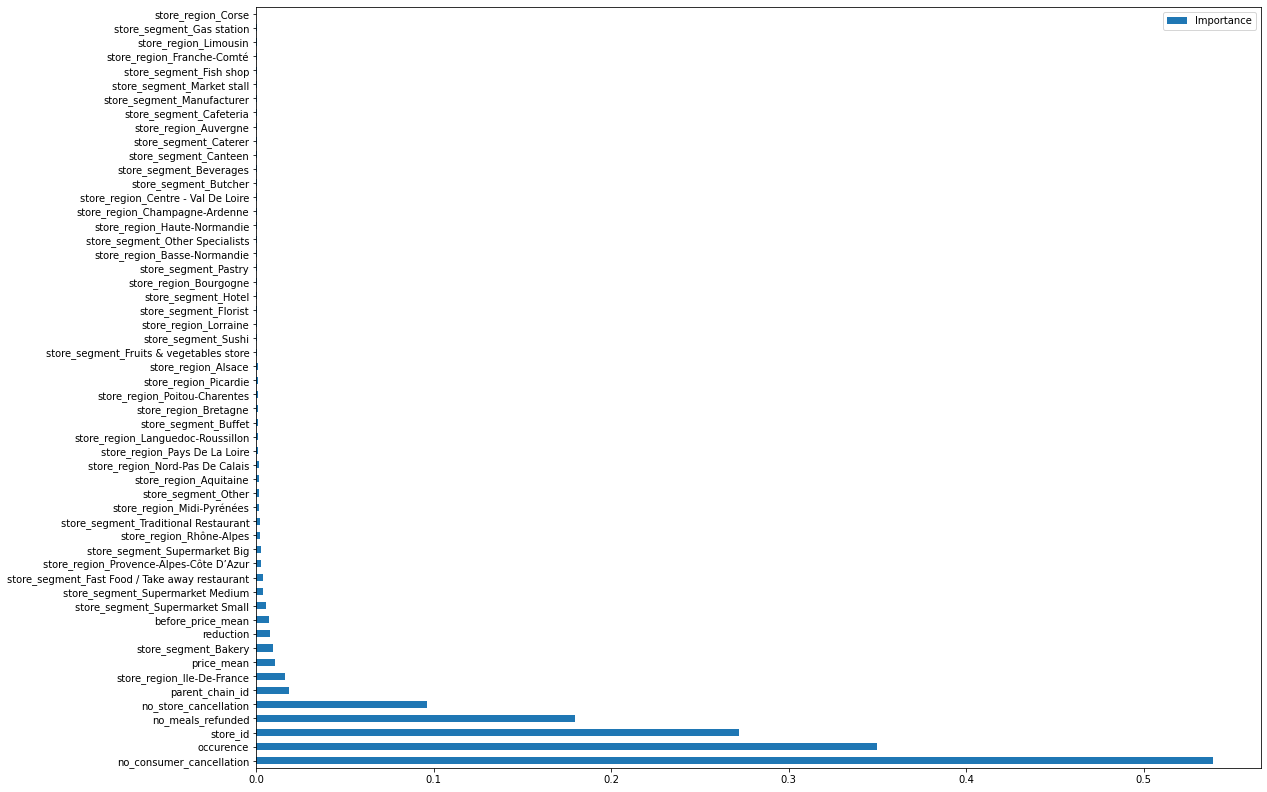

In [529]:
importance.plot(kind = 'barh', figsize = (18, 14))

In [530]:
# On définit les échantillons

y = df1[['proportion_of_target_hit']]
X = df1.drop(columns = ['proportion_of_target_hit'])

In [533]:
# Construction de l'architecture du réseau

model = Sequential()

model.add(Dense(70, input_dim = 54, activation = 'relu'))

model.add(Dense(12))
model.add(Dense(13))
model.add(Dense(15))
model.add(Dense(5))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [534]:
# Lancement de la phase d'apprentissage

history = model.fit(X, y, validation_split = 0.2,  epochs = 30)

Epoch 1/30
448/448 [==============================] - 2s 2ms/step - loss: 0.0865 - val_loss: 0.0949
Epoch 2/30
448/448 [==============================] - 1s 3ms/step - loss: 0.0473 - val_loss: 0.1031
Epoch 3/30
448/448 [==============================] - 1s 3ms/step - loss: 0.0399 - val_loss: 0.0959
Epoch 4/30
448/448 [==============================] - 1s 2ms/step - loss: 0.0347 - val_loss: 0.0918
Epoch 5/30
448/448 [==============================] - 1s 3ms/step - loss: 0.0320 - val_loss: 0.0829
Epoch 6/30
448/448 [==============================] - 1s 3ms/step - loss: 0.0294 - val_loss: 0.0920
Epoch 7/30
448/448 [==============================] - 1s 2ms/step - loss: 0.0293 - val_loss: 0.0736
Epoch 8/30
448/448 [==============================] - 1s 2ms/step - loss: 0.0279 - val_loss: 0.0610
Epoch 9/30
448/448 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.0684
Epoch 10/30
448/448 [==============================] - 1s 2ms/step - loss: 0.0273 - val_loss: 0.0658

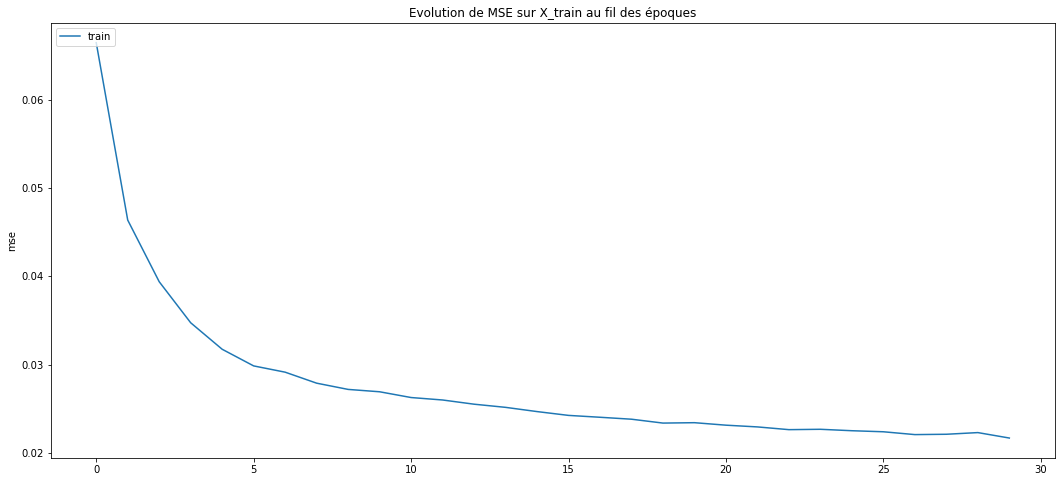

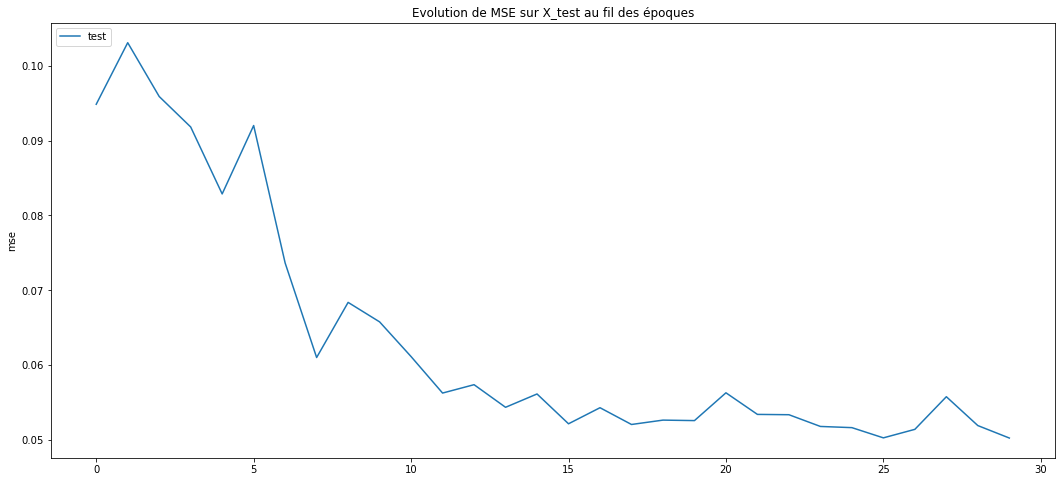

In [535]:
# On affiche l'évolution de la loss au fil des époques pour les échantillons train et test.

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(history.history['loss'])
plt.title('Evolution de MSE sur X_train au fil des époques')
plt.ylabel('mse')
plt.legend(['train'], loc = 'upper left')
plt.show()

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(history.history['val_loss'])
plt.title('Evolution de MSE sur X_test au fil des époques')
plt.ylabel('mse')
plt.legend(['test'], loc = 'upper left')
plt.show()

In [536]:
perm = PermutationImportance(model, scoring = 'r2', random_state = 1).fit(X,y)

In [537]:
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.3966 ± 0.0076,no_consumer_cancellation
0.3535 ± 0.0085,store_id
0.2512 ± 0.0095,occurence
0.2071 ± 0.0083,no_meals_refunded
0.1114 ± 0.0050,store_region_Ile-De-France
0.0586 ± 0.0047,no_store_cancellation
0.0553 ± 0.0047,store_segment_Bakery
0.0551 ± 0.0030,store_segment_Supermarket Small
0.0537 ± 0.0027,store_region_Rhône-Alpes
0.0452 ± 0.0034,store_region_Provence-Alpes-Côte D’Azur


In [540]:
import xgboost as xgb


In [581]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 40)

In [582]:
y = df1[['proportion_of_target_hit']]
X = df1.drop(columns = ['proportion_of_target_hit'])

# On choisit un échantillon de validation de 20 %

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [583]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[21:47:23] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [584]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.161184


<AxesSubplot:>

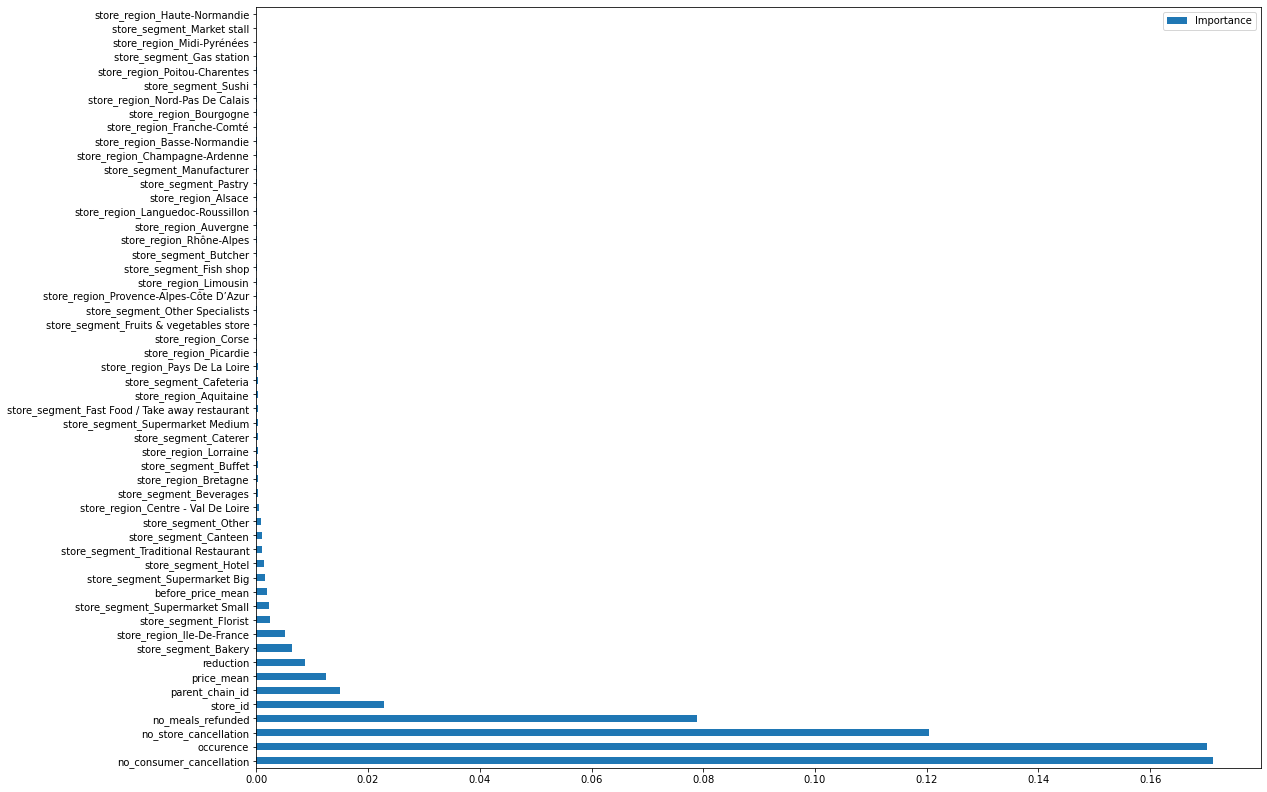

In [585]:
importance = feat_importance(xg_reg, x_train, y_train, X)
importance.plot(kind = 'barh', figsize = (18, 14))